In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from deap import base, creator, tools, benchmarks, cma

In [6]:
# Create Fitness class
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# Create Individual class
creator.create("Individual", list, fitness=creator.FitnessMin)

# Create Toolbox
toolbox = base.Toolbox()
toolbox.register("evaluate", benchmarks.ackley)

/home/ryoaki374/.deap/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/ryoaki374/.deap/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [7]:
# Set a random seed for reproducibility
random.seed(42)
np.random.seed(128)

# GA parameters
POP_SIZE = 1000
CX_PB = 0.5  # Crossover probability
MUT_PB = 0.2 # Mutation probability
N_GEN = 100
N_DIM = 2

In [8]:
# cma-es parameters
strategy = cma.Strategy(centroid=[5.0]*N_DIM, sigma=5.0, lambda_=20*N_DIM)

In [9]:
toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)

In [10]:
# Create Hall of Fame to store the best individual <-- 最終世代以外の途中のベストも保存するオブジェクト
hof = tools.HallOfFame(1)

# 統計情報とログの設定
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()
logbook.header = "gen", "nevals", "min", "avg", "std"

In [11]:
# 1. 最初の世代の適応度を評価
# generate
pop = toolbox.generate()
# Evaluate the fitness of the entire population
invalid_ind = [ind for ind in pop if not ind.fitness.valid]
#fitnesses = list(map(toolbox.evaluate, invalid_ind))
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)

# Assign fitness values (output of the ackley) to individuals
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

In [12]:
# update the strategy with the evaluated individuals
toolbox.update(pop)

# LogbookとHallOfFameを最初の世代で更新
hof.update(pop)
record = stats.compile(pop)
logbook.record(gen=0, nevals=len(invalid_ind), **record)
print(logbook.stream) # 最初の世代の統計情報を表示

gen	nevals	min    	avg   	std    
0  	40    	6.17157	15.284	3.30119


In [13]:
# Start evolution loop
for gen in tqdm(range(1, N_GEN + 1)):

    # generate new population
    population = toolbox.generate()

    # Evaluate the fitness of the entire population
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # update the strategy with the evaluated individuals
    toolbox.update(population)

    # Update Hall of Fame and logbook
    hof.update(population)
    record = stats.compile(population)
    logbook.record(gen=gen, nevals=len(invalid_ind), **record)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 1078.93it/s]



-- End of (successful) evolution --
individual: [np.float64(-1.9342128635580987e-16), np.float64(4.591610541503932e-17)]
fitness: 0.0


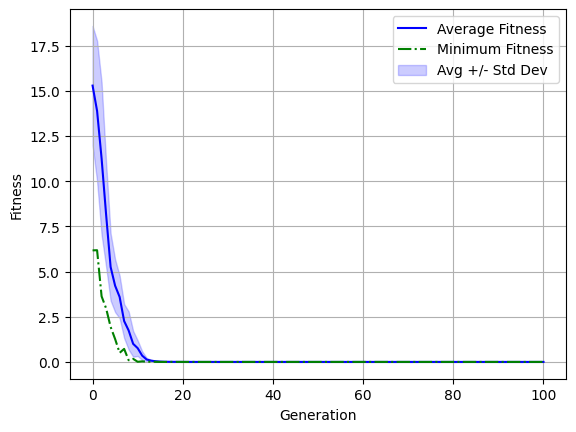

In [15]:
# show final results
print("\n-- End of (successful) evolution --")
print(f"individual: {hof[0]}")
print(f"fitness: {hof[0].fitness.values[0]}")

# --- graph ---
gen = logbook.select("gen")
avg = logbook.select("avg")
std = logbook.select("std")
min_ = logbook.select("min")
fig, ax1 = plt.subplots()

# mean with solid line
line1 = ax1.plot(gen, avg, "b-", label="Average Fitness")

# min with dashed line
line2 = ax1.plot(gen, min_, "g-.", label="Minimum Fitness")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

# std deviation as shaded area
std_upper = np.array(avg) + np.array(std)
std_lower = np.array(avg) - np.array(std)
ax1.fill_between(gen, std_lower, std_upper, color='b', alpha=0.2, label="Avg +/- Std Dev")

ax1.legend(loc="upper right")
plt.grid(True)
plt.show()